# Lung Disease Diagnosis - Model Tuning

Developer: Tung Nguyen

This notebook is a continuation of model-tuning-2.ipynb

The best performing model from model-tuning-1.ipynb and model-tuning-2.ipynb, based on AUPR, is the Xception model trained on a stratified subset of data. 

This notebook trains an Xception model on a stratified bootstrap of the full dataset (model-8a) and as a baseline, on the full dataset with no sampling applied (model-10a).

## Data Prep
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_Xception

from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K
from tensorflow import cast, float32

from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../chest-x-ray-data/Data_Entry_2017.csv')
df = df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=False)

mlb = MultiLabelBinarizer()
lbl_bins = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_bin = df.join(pd.DataFrame(lbl_bins, columns=mlb.classes_))

with open('../chest-x-ray-data/train_val_list.txt', 'r') as f:
    train_list = f.read().split('\n')

with open('../chest-x-ray-data/test_list.txt', 'r') as f:
    test_list = f.read().split('\n')

df_train_val = df_bin[df_bin['Image Index'].isin(train_list)]
df_test = df_bin[df_bin['Image Index'].isin(test_list)]

df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=1)

In [3]:
print(df_train_val.shape)
print(df_train.shape)
print(df_val.shape)
print()
print(df_test.shape)

(86524, 22)
(69219, 22)
(17305, 22)

(25596, 22)


In [4]:
labels = [lbl for lbl in mlb.classes_ if lbl != 'No Finding']

In [5]:
def plot_df_freq(df, labels, title=''):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');
    ax.bar_label(ax.containers[0])
    
    return df_pos

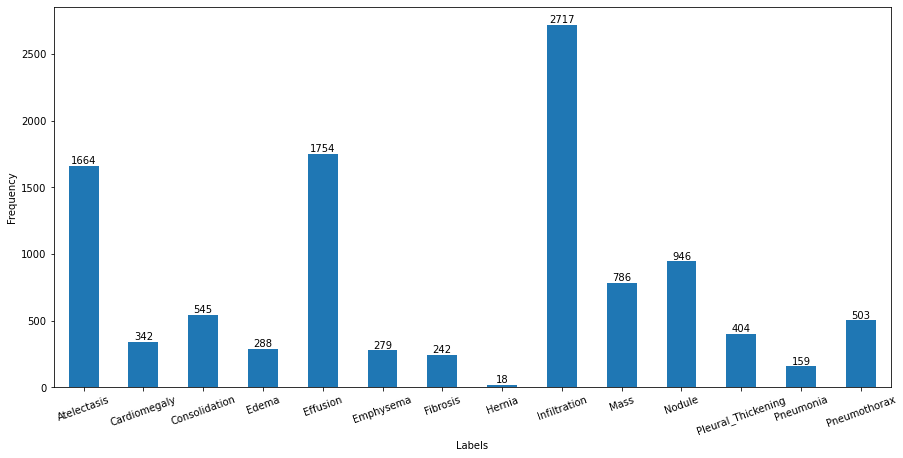

In [44]:
plot_df_freq(df_val, labels);

### Data Sampling

In [6]:
# Stratified Sampling for Data Augmentation
stratified_sampled_df_train = pd.DataFrame([])

n = 6100

# Sample each label
for lbl in mlb.classes_:
    temp = df_train[df_train[lbl] == 1].sample(
        n,
        replace=True,
        random_state=1
    )
    
    stratified_sampled_df_train = pd.concat([stratified_sampled_df_train, temp])

In [7]:
stratified_sampled_df_train.shape

(91500, 22)

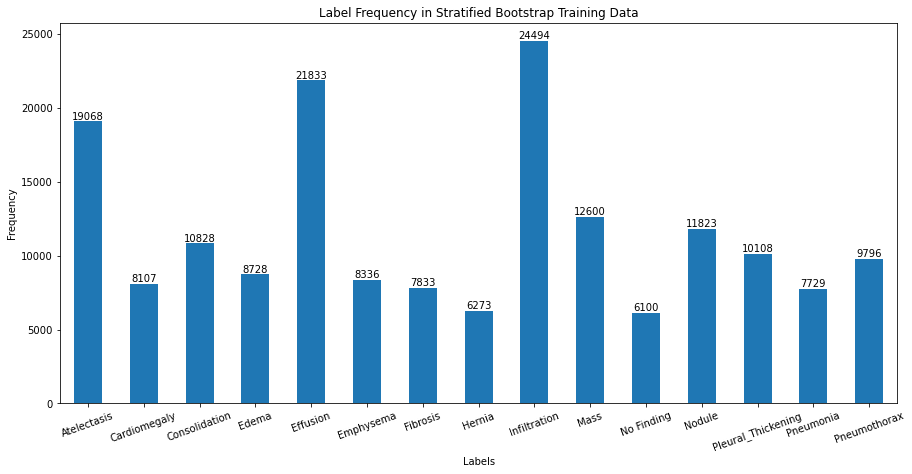

In [8]:
plot_df_freq(stratified_sampled_df_train, mlb.classes_, title='Label Frequency in Stratified Bootstrap Training Data');

### Helper Functions

In [9]:
def plot_losses(model_history, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

In [10]:
def datagen_from_df(df, x_col, y_cols, data_dir, preproc_func=None, target_size=(256, 256), shuffle=False, batch_size=64, color_mode='rgb', random_state=1):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        horizontal_flip=True,
        vertical_flip=False,
        height_shift_range=0.05,
        width_shift_range=0.1,
        rotation_range=5,
        shear_range=0.1,
        fill_mode='reflect',
        zoom_range=0.15,
    )

    img_generator = datagen.flow_from_dataframe(
        df,
        data_dir,
        shuffle=shuffle,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        seed=random_state
    )

    return img_generator

In [11]:
# Callbacks
early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.00001
)

chkpt = {}    
base_path = './models/'

for i in ['8a', '8b']:

    chkpt[i] = ModelCheckpoint(
        base_path + 'model-' + str(i) + '.h5', 
        monitor='val_loss',
        verbose=1, 
        save_best_only=True, 
        mode='min', 
    )

## Models
---

### DataGenerators

In [12]:
data_dir = '../chest-x-ray-data/imgs/'

In [13]:
train_gen = {}
val_gen = {}

for i in ['8a', '8b']:
    val_gen[i] = datagen_from_df(
        df_val, 
        x_col = 'Image Index', 
        y_cols = labels, 
        data_dir = data_dir, 
        preproc_func = preprocess_input_Xception, 
        target_size = (256, 256), 
        shuffle=False,
        batch_size = 64, 
        color_mode = 'rgb', 
        random_state = 1
        )


# Xception models
train_gen['8a'] = datagen_from_df(
    stratified_sampled_df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_Xception, 
    target_size = (256, 256), 
    shuffle=True,
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

train_gen['8b'] = datagen_from_df(
    df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_Xception, 
    target_size = (256, 256), 
    shuffle=True,
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

Found 17305 validated image filenames.
Found 17305 validated image filenames.
Found 91500 validated image filenames.
Found 69219 validated image filenames.


In [14]:
history = {}

### Model 8a

In [15]:
# Base Models
base_model_Xc_1 = Xception(
    include_top=False,
    weights="imagenet",
    pooling="max",
    input_shape=(256, 256, 3)
)

output_layer_Xc_1 = Dense(len(labels), activation='sigmoid')(base_model_Xc_1.output)
model_Xc_1 = Model(base_model_Xc_1.input, output_layer_Xc_1)

for layer in model_Xc_1.layers:
    layer.trainable = True

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-06-07 06:46:22.530161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-07 06:46:22.530280: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
model_Xc_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [17]:
m = '8a'

history[m] = model_Xc_1.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-07 06:46:24.545603: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-07 06:46:26.944293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1430/1430 [==============================] - ETA: 0s - loss: 0.2883 - auc: 0.4782 - auc_1: 0.8150

2022-06-07 07:15:48.577573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.18238, saving model to ./models/model-8a.h5
1430/1430 [==============================] - 2036s 1s/step - loss: 0.2883 - auc: 0.4782 - auc_1: 0.8150 - val_loss: 0.1824 - val_auc: 0.1671 - val_auc_1: 0.7608 - lr: 0.0010
Epoch 2/40
1430/1430 [==============================] - ETA: 0s - loss: 0.2217 - auc: 0.6861 - auc_1: 0.9005
Epoch 2: val_loss did not improve from 0.18238
1430/1430 [==============================] - 2039s 1s/step - loss: 0.2217 - auc: 0.6861 - auc_1: 0.9005 - val_loss: 0.1913 - val_auc: 0.1830 - val_auc_1: 0.7542 - lr: 0.0010
Epoch 3/40
1430/1430 [==============================] - ETA: 0s - loss: 0.1653 - auc: 0.8240 - auc_1: 0.9464
Epoch 3: val_loss did not improve from 0.18238
1430/1430 [==============================] - 2029s 1s/step - loss: 0.1653 - auc: 0.8240 - auc_1: 0.9464 - val_loss: 0.2126 - val_auc: 0.1820 - val_auc_1: 0.7417 - lr: 0.0010
Epoch 4/40
1430/1430 [==============================] - ETA: 0s - loss: 0.1202 -

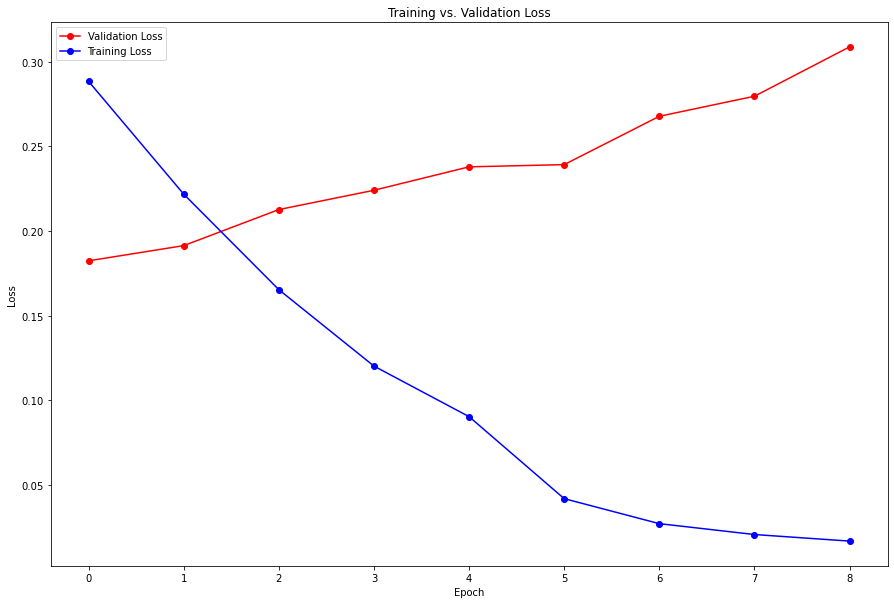

In [18]:
plot_losses(history[m])

### Model 8b

In [15]:
# Base Models
base_model_Xc_2 = Xception(
    include_top=False,
    weights="imagenet",
    pooling="max",
    input_shape=(256, 256, 3)
)

output_layer_Xc_2 = Dense(len(labels), activation='sigmoid')(base_model_Xc_2.output)
model_Xc_2 = Model(base_model_Xc_2.input, output_layer_Xc_2)

for layer in model_Xc_2.layers:
    layer.trainable = True

2022-06-08 06:26:37.663523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-08 06:26:37.663643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [16]:
model_Xc_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [17]:
m = '8b'

history[m] = model_Xc_2.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-08 06:26:42.015513: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-08 06:26:44.373679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1082/1082 [==============================] - ETA: 0s - loss: 0.1474 - auc: 0.1263 - auc_1: 0.7272

2022-06-08 06:49:00.470790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.14246, saving model to ./models/model-8b.h5
1082/1082 [==============================] - 1603s 1s/step - loss: 0.1474 - auc: 0.1263 - auc_1: 0.7272 - val_loss: 0.1425 - val_auc: 0.1644 - val_auc_1: 0.7560 - lr: 0.0010
Epoch 2/40
1082/1082 [==============================] - ETA: 0s - loss: 0.1378 - auc: 0.1784 - auc_1: 0.7806
Epoch 2: val_loss improved from 0.14246 to 0.13789, saving model to ./models/model-8b.h5
1082/1082 [==============================] - 1616s 1s/step - loss: 0.1378 - auc: 0.1784 - auc_1: 0.7806 - val_loss: 0.1379 - val_auc: 0.1919 - val_auc_1: 0.7784 - lr: 0.0010
Epoch 3/40
1082/1082 [==============================] - ETA: 0s - loss: 0.1349 - auc: 0.1972 - auc_1: 0.7951
Epoch 3: val_loss did not improve from 0.13789
1082/1082 [==============================] - 1629s 2s/step - loss: 0.1349 - auc: 0.1972 - auc_1: 0.7951 - val_loss: 0.1384 - val_auc: 0.1886 - val_auc_1: 0.7678 - lr: 0.0010
Epoch 4/40
1082/1082 [================

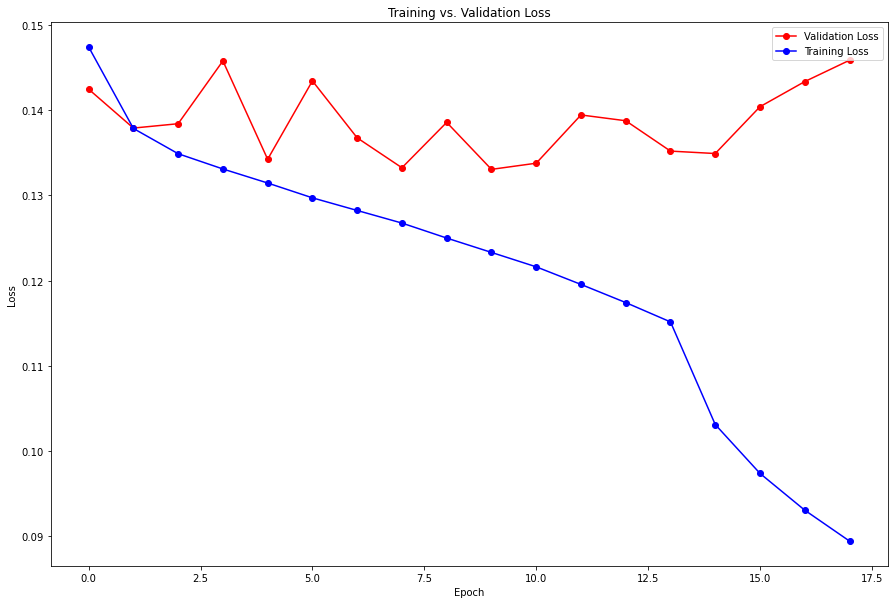

In [18]:
plot_losses(history[m])

## Model Evaluation
---

In [19]:
import csv
from tensorflow.keras.models import load_model

In [20]:
def plot_roc_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):
    
    csv_writer.writerow(['label', 'fpr', 'tpr', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(fpr), fpr, tpr, thresholds))

    ax.legend()
    ax.set_title('ROC Curves - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

def plot_precision_recall_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):

    csv_writer.writerow(['pr', 'rc', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(rc, pr)
        ax.plot(rc, pr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(pr), pr, rc, thresholds))

    ax.legend()
    ax.set_title('Precision-Recall Curve - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

In [21]:
for i in ['8a', '8b']:
    model_name = 'model-' + str(i)

    roc_jpg = './results/roc-' + model_name + '.jpg'
    roc_csv = './results/roc-' + model_name + '.csv'
    auroc_csv = './results/auroc-' + model_name + '.csv'
    pr_jpg = './results/pr-' + model_name + '.jpg'
    pr_csv = './results/pr-' + model_name + '.csv'
    aupr_csv= './results/aupr-' + model_name + '.csv'
    
    model = load_model('./models/' + model_name + '.h5', compile=False)

    val_gen[i].reset()
    y_true = val_gen[i].labels
    y_pred = model.predict(val_gen[i], batch_size=64, verbose=True)

    with open(roc_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_roc_auc(y_true, y_pred, labels, model_name, roc_jpg, csv_writer, figsize=(15, 10))
    
    with open(auroc_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

    with open(pr_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_precision_recall_auc(y_true, y_pred, labels, model_name, pr_jpg, csv_writer, figsize=(15, 10))

    with open(aupr_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

2022-06-08 15:03:12.012493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 271s 998ms/step


2022-06-08 15:07:45.209640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 276s 1s/step


### Area Under ROC Curve

In [22]:
import os

def highlight_max(s, props=''):
    return np.where(s == np.max(s.values), props, '')

def highlight_min(s, props=''):
    return np.where(s == np.min(s.values), props, '')

results_dir = r'./results/'
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'auroc' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()
df = df[['auroc-model-' + str(x) + '.csv' for x in ['8a', '8b']]]

df.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption('SUMMARY - Area Under ROC Curve')

File,auroc-model-8a.csv,auroc-model-8b.csv
Atelectasis,0.723303,0.823255
Cardiomegaly,0.885604,0.909985
Consolidation,0.729629,0.805555
Edema,0.869216,0.887776
Effusion,0.815483,0.885907
Emphysema,0.816912,0.884664
Fibrosis,0.727623,0.798684
Hernia,0.894940,0.914438
Infiltration,0.638512,0.707557
Mass,0.768920,0.837972


In [23]:
print('Average AUROC:')
for ind, col in df.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUROC:
auroc-model-8a.csv: 0.763989
auroc-model-8b.csv: 0.829601


### Area Under PR Curve

In [24]:
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'aupr' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()
df = df[['aupr-model-' + str(x) + '.csv' for x in ['8a', '8b']]]

df.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption("SUMMARY - Area Under PR Curve")

File,aupr-model-8a.csv,aupr-model-8b.csv
Atelectasis,0.237805,0.368444
Cardiomegaly,0.222929,0.256951
Consolidation,0.085783,0.119068
Edema,0.158703,0.176432
Effusion,0.431982,0.524764
Emphysema,0.175567,0.283866
Fibrosis,0.076199,0.099746
Hernia,0.146093,0.505019
Infiltration,0.267312,0.323792
Mass,0.221071,0.294276


In [25]:
print('Average AUPR:')
for ind, col in df.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUPR:
aupr-model-8a.csv: 0.172616
aupr-model-8b.csv: 0.258027


# Conclusions

* When trained on the full dataset, model 8b performs better with respects to both AUROC and AUPR for all labels. Stratified sampling is not a good substitution for more data! 

* model 8b will be deployed as a streamlit app.

The ROC and PR curves for model 8b are shown below.

![image](./results/roc-model-8b.jpg)

![image](./results/pr-model-8b.jpg)

## Selection of Classification Threshold for Deployment

* Picking a classification threshold relies heavily on domain-specific knowledge as well as the specific use-case of the model.

* Plots and data in this section were generated to characterize the behavior of the model under different thresholds, and is meant to be an aid for threshold selection if this were a real deployment.

* Due to a lack of a use-case or domain-specific knowledge for this project, a threshold = 0.5 will be selected.

In [26]:
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score, confusion_matrix

In [28]:
model = load_model('./models/model-8b.h5', compile=False)

val_gen['8b'].reset()
y_true = val_gen['8b'].labels
y_pred = model.predict(val_gen['8b'], batch_size=128, verbose=True)

2022-06-08 18:55:07.183050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 275s 1s/step


In [29]:
def prob2class(y_pred, threshold):
    return np.array([[1. if x >= threshold else 0. for x in arr] for arr in y_pred])

In [32]:
# Calculate multi-label metrics, averaged over samples

thresholds = np.linspace(0.01, 0.99, 99)

metrics_df = pd.DataFrame(columns=['threshold', 'accuracy', 'hamming_loss', 'precision', 'recall', 'f1'])
for threshold in thresholds:

    # Round-off issue with Apple M1 & numpy
    threshold = round(threshold, 2)
    
    y_pred_threshold = prob2class(y_pred, threshold)

    temp = pd.DataFrame({
        'threshold': [threshold],
        'accuracy': [accuracy_score(y_true, y_pred_threshold, normalize=True, sample_weight=None)],
        'hamming_loss': [hamming_loss(y_true, y_pred_threshold)],
        'precision': [precision_score(y_true, y_pred_threshold, average='samples', zero_division=0)], 
        'recall': [recall_score(y_true, y_pred_threshold, average='samples', zero_division=0)],
        'f1': [f1_score(y_true, y_pred_threshold, average='samples', zero_division=0)]
    })

    metrics_df = pd.concat([metrics_df, temp])

In [33]:
metrics_df

,threshold,accuracy,hamming_loss,precision,recall,f1
0,0.01,0.003178,0.450023,0.077762,0.387576,0.123574
0,0.02,0.017163,0.319945,0.101301,0.363871,0.147619
0,0.03,0.038197,0.250923,0.119312,0.345751,0.164004
0,0.04,0.060445,0.208292,0.131211,0.327715,0.173196
0,0.05,0.086044,0.180654,0.140383,0.314471,0.179436
...,...,...,...,...,...,...
0,0.95,0.586709,0.043922,0.000405,0.000299,0.000327
0,0.96,0.586767,0.043922,0.000347,0.000279,0.000299
0,0.97,0.586767,0.043922,0.000347,0.000279,0.000299
0,0.98,0.586651,0.04393,0.000231,0.000164,0.000183


In [34]:
metrics_df.max()

threshold           0.99
accuracy        0.593297
hamming_loss    0.450023
precision       0.169195
recall          0.387576
f1              0.188832
dtype: object

In [35]:
metrics_df.min()

threshold           0.01
accuracy        0.003178
hamming_loss    0.042432
precision       0.000231
recall          0.000164
f1              0.000183
dtype: object

/Users/tungnguyen/miniforge3/envs/tf-gpu/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


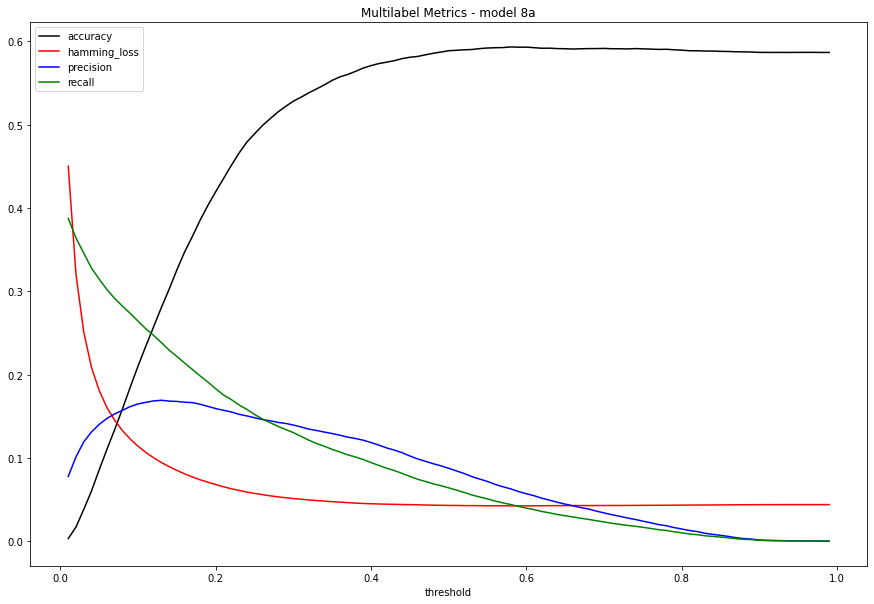

In [36]:
metrics_df.plot(
    kind='line', 
    x='threshold', 
    y=['accuracy', 'hamming_loss', 'precision', 'recall'], 
    color=['black', 'red', 'blue', 'green'], 
    figsize=(15, 10)
    )
ax = plt.gca()
ax.set_title('Multilabel Metrics - model 8a');

* Accuracy score in the plot above is a harsh metric as the set of labels predicted for a sample must exactly match the corresponding labels in y_true

* Hamming loss is a less harsh metric, and is the fraction of labels that are incorrectly predicted, (e.g. 1 - accuracy for the binary case). 

* Precision, recall, and f1 in the plot above is calculated for each instance, then averaged over all samples.

In [38]:
# Calculate binary metrics for each individual label
ind_metrics_df = pd.DataFrame(columns=['label', 'threshold', 'accuracy', 'precision', 'recall', 'f1'])
for threshold in thresholds:
    
    # Round-off issue with Apple M1 & numpy
    threshold = round(threshold, 2)
    y_pred_threshold = prob2class(y_pred, threshold)

    for i, lbl in enumerate(labels):

        tn, fp, fn, tp = confusion_matrix(y_true[:, i], y_pred_threshold[:, i]).ravel()
        
        temp = pd.DataFrame({
            'label': [lbl],
            'threshold': [threshold],
            'accuracy': [accuracy_score(y_true[:, i], y_pred_threshold[:, i])],
            'precision': [precision_score(y_true[:, i], y_pred_threshold[:, i], zero_division=0)], 
            'recall': [recall_score(y_true[:, i], y_pred_threshold[:, i])],
            'f1': [f1_score(y_true[:, i], y_pred_threshold[:, i])],
            'tn': [tn],
            'fp': [fp],
            'fn': [fn],
            'tp': [tp]
            })
        ind_metrics_df = pd.concat([ind_metrics_df, temp])

In [39]:
ind_metrics_df

,label,threshold,accuracy,precision,recall,f1,tn,fp,fn,tp
0,Atelectasis,0.01,0.403987,0.135513,0.966346,0.237694,5383.0,10258.0,56.0,1608.0
0,Cardiomegaly,0.01,0.811268,0.083001,0.850877,0.151247,13748.0,3215.0,51.0,291.0
0,Consolidation,0.01,0.510431,0.055113,0.900917,0.103871,8342.0,8418.0,54.0,491.0
0,Edema,0.01,0.63577,0.040629,0.923611,0.077835,10736.0,6281.0,22.0,266.0
0,Effusion,0.01,0.37284,0.137172,0.980616,0.240677,4732.0,10819.0,34.0,1720.0
...,...,...,...,...,...,...,...,...,...,...
0,Mass,0.99,0.95458,0.0,0.0,0.0,16519.0,0.0,786.0,0.0
0,Nodule,0.99,0.945334,0.0,0.0,0.0,16359.0,0.0,946.0,0.0
0,Pleural_Thickening,0.99,0.976654,0.0,0.0,0.0,16901.0,0.0,404.0,0.0
0,Pneumonia,0.99,0.990812,0.0,0.0,0.0,17146.0,0.0,159.0,0.0


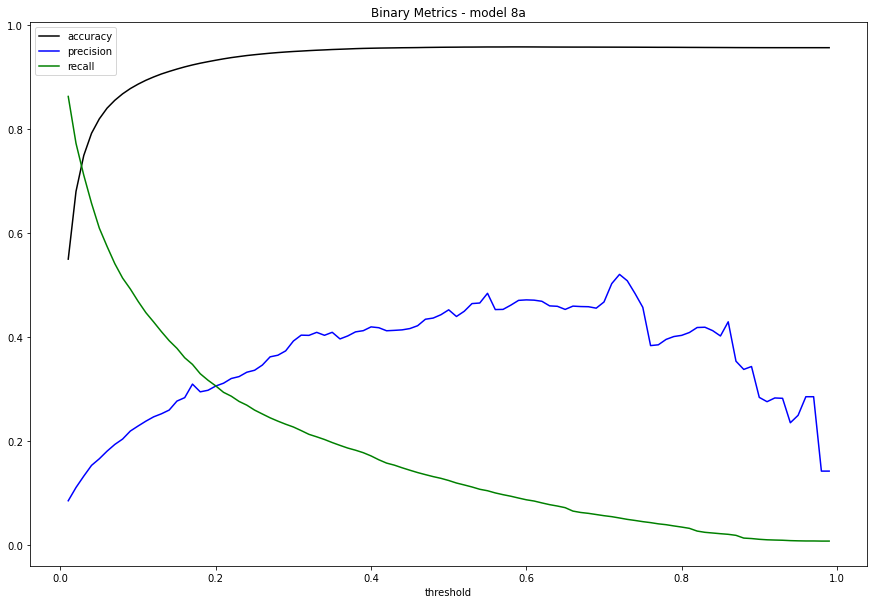

In [40]:
ind_metrics_df[['threshold', 'accuracy', 'precision', 'recall']].groupby('threshold').agg('mean').plot(kind='line', color=['black', 'blue', 'green'], figsize=(15, 10))
ax = plt.gca()
ax.set_title('Binary Metrics - model 8a');

* The plot above treats the problem as multiple binary classification problems, calculates metrics, and then averages over the labels.

* The precision-recall trade-off can also be seen.

In [41]:
metrics_df[metrics_df.threshold == 0.5]

,threshold,accuracy,hamming_loss,precision,recall,f1
0,0.5,0.588732,0.042993,0.087499,0.064043,0.070276


In [42]:
pd.set_option('display.max_rows', 14)
ind_metrics_df[ind_metrics_df.threshold == 0.5]

,label,threshold,accuracy,precision,recall,f1,tn,fp,fn,tp
0,Atelectasis,0.5,0.907194,0.679012,0.066106,0.120482,15589.0,52.0,1554.0,110.0
0,Cardiomegaly,0.5,0.980468,0.543478,0.073099,0.128866,16942.0,21.0,317.0,25.0
0,Consolidation,0.5,0.968448,0.0,0.0,0.0,16759.0,1.0,545.0,0.0
0,Edema,0.5,0.982895,0.433333,0.090278,0.149425,16983.0,34.0,262.0,26.0
0,Effusion,0.5,0.910893,0.577599,0.449829,0.505769,14974.0,577.0,965.0,789.0
0,Emphysema,0.5,0.984109,0.515152,0.243728,0.3309,16962.0,64.0,211.0,68.0
0,Fibrosis,0.5,0.9859,0.428571,0.024793,0.046875,17055.0,8.0,236.0,6.0
0,Hernia,0.5,0.999191,0.833333,0.277778,0.416667,17286.0,1.0,13.0,5.0
0,Infiltration,0.5,0.841144,0.475155,0.112624,0.182089,14250.0,338.0,2411.0,306.0
0,Mass,0.5,0.954811,0.512048,0.108142,0.178571,16438.0,81.0,701.0,85.0


* Using the default threshold of 0.5, the model has accuracy > 0.90 for most diseases except for Infiltration.

* However, accuracy alone does not mean a model is behaving well. Looking at Pneumonia, which has an accuracy of 0.99, the model was not able to accurately predict any positive occurences in the validation set (FN = 159, TP = 0). A similar case is present for Consolidation.

# AUC on Test Data

* Final model metrics for model 8a are calculated below

In [45]:
test_gen = {}

test_gen['8b'] = datagen_from_df(
    df_test, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_Xception, 
    target_size = (256, 256), 
    shuffle=False,
    batch_size = 128, 
    color_mode = 'rgb', 
    random_state = 1
    )

Found 25596 validated image filenames.


In [47]:
for i in ['8b']:
    model_name = 'model-' + str(i)

    roc_jpg = './results/test-data-roc-' + model_name + '.jpg'
    roc_csv = './results/test-data-roc-' + model_name + '.csv'
    auroc_csv = './results/test-data-auroc-' + model_name + '.csv'
    pr_jpg = './results/test-data-pr-' + model_name + '.jpg'
    pr_csv = './results/test-data-pr-' + model_name + '.csv'
    aupr_csv= './results/test-data-aupr-' + model_name + '.csv'
    
    model = load_model('./models/' + model_name + '.h5', compile=False)

    y_true = test_gen[i].labels
    y_pred = model.predict(test_gen[i], batch_size=128, verbose=True)

    with open(roc_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_roc_auc(y_true, y_pred, labels, model_name, roc_jpg, csv_writer, figsize=(15, 10))
    
    with open(auroc_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

    with open(pr_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_precision_recall_auc(y_true, y_pred, labels, model_name, pr_jpg, csv_writer, figsize=(15, 10))

    with open(aupr_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

2022-06-08 19:23:32.123888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 404s 2s/step


![image](./results/test-data-roc-model-8b.jpg)

![image](./results/test-data-pr-model-8b.jpg)

In [49]:
# Calculate multi-label metrics, averaged over samples
thresholds = [0.5]

metrics_df = pd.DataFrame(columns=['threshold', 'accuracy', 'hamming_loss', 'precision', 'recall', 'f1'])
for threshold in thresholds:

    # Round-off issue with Apple M1 & numpy
    threshold = round(threshold, 2)
    
    y_pred_threshold = prob2class(y_pred, threshold)

    temp = pd.DataFrame({
        'threshold': [threshold],
        'accuracy': [accuracy_score(y_true, y_pred_threshold, normalize=True, sample_weight=None)],
        'hamming_loss': [hamming_loss(y_true, y_pred_threshold)],
        'precision': [precision_score(y_true, y_pred_threshold, average='samples', zero_division=0)], 
        'recall': [recall_score(y_true, y_pred_threshold, average='samples', zero_division=0)],
        'f1': [f1_score(y_true, y_pred_threshold, average='samples', zero_division=0)]
    })

    metrics_df = pd.concat([metrics_df, temp])

metrics_df

,threshold,accuracy,hamming_loss,precision,recall,f1
0,0.5,0.369862,0.075854,0.179156,0.125125,0.138398


In [51]:
# Calculate binary metrics for each individual label
ind_metrics_df = pd.DataFrame(columns=['label', 'threshold', 'accuracy', 'precision', 'recall', 'f1'])
for threshold in thresholds:
    
    # Round-off issue with Apple M1 & numpy
    threshold = round(threshold, 2)
    y_pred_threshold = prob2class(y_pred, threshold)

    for i, lbl in enumerate(labels):

        tn, fp, fn, tp = confusion_matrix(y_true[:, i], y_pred_threshold[:, i]).ravel()
        
        temp = pd.DataFrame({
            'label': [lbl],
            'threshold': [threshold],
            'accuracy': [accuracy_score(y_true[:, i], y_pred_threshold[:, i])],
            'precision': [precision_score(y_true[:, i], y_pred_threshold[:, i], zero_division=0)], 
            'recall': [recall_score(y_true[:, i], y_pred_threshold[:, i])],
            'f1': [f1_score(y_true[:, i], y_pred_threshold[:, i])],
            'tn': [tn],
            'fp': [fp],
            'fn': [fn],
            'tp': [tp]
            })
        ind_metrics_df = pd.concat([ind_metrics_df, temp])

ind_metrics_df

,label,threshold,accuracy,precision,recall,f1,tn,fp,fn,tp
0,Atelectasis,0.5,0.87291,0.591549,0.025618,0.049108,22259.0,58.0,3195.0,84.0
0,Cardiomegaly,0.5,0.958744,0.558559,0.057998,0.105085,24478.0,49.0,1007.0,62.0
0,Consolidation,0.5,0.92909,0.0,0.0,0.0,23781.0,0.0,1815.0,0.0
0,Edema,0.5,0.962338,0.344,0.046486,0.081905,24589.0,82.0,882.0,43.0
0,Effusion,0.5,0.828606,0.535799,0.43538,0.480398,19181.0,1757.0,2630.0,2028.0
0,Emphysema,0.5,0.957728,0.507757,0.329369,0.399556,24154.0,349.0,733.0,360.0
0,Fibrosis,0.5,0.982458,0.208333,0.011494,0.021786,25142.0,19.0,430.0,5.0
0,Hernia,0.5,0.99707,0.823529,0.162791,0.271845,25507.0,3.0,72.0,14.0
0,Infiltration,0.5,0.749648,0.460022,0.278632,0.347055,17485.0,1999.0,4409.0,1703.0
0,Mass,0.5,0.932802,0.541667,0.104119,0.174664,23694.0,154.0,1566.0,182.0


# Areas for Improvement & Further Experimentation

* Tweaking the classification threshold for each label - Choosing the default classification threshold of 0.5 leads to poor behavior in Consolidation and Pneumonia, but potentially acceptable behavior (depending on use-case) for all the other labels. This approach would need to be rigorously studied as it can result in overfitting to the training/validation data.

* More preprocessing of images - Parsing through the chest x-ray images, one can see the large amount of noise within the images themselves. Some images are zoomed in, some are taken from the side instead of front/back, and others have reference notes added by the radiologist which obscure part of the chest. Further standardization of the images is needed for this dataset.

* Scaling up and/or different architectures - there exists larger models than Xception and DenseNet169. Going from VGG16 from Xception improved the metrics for all labels, thus, it is reasonable to believe scaling up improves accuracy (but at the cost of more training time).

* Improving true labels - the labels from this dataset are obtained using NLP, which means some of the true labels are actually false. While the maintainers of the data predict a 90% accuracy for the true labels, this still means around ~10,000 images are incorrectly labeled. Correcting the true labels will help reduce noise.